In [1]:
%pip install -qU langchain langchain-google-genai langchain_community tavily-python aiosqlite langchain-tavily 
%pip install -qU langgraph-checkpoint-sqlite 
%pip install -qU langgraph langgraph-checkpoint-sqlite
%pip install -qU langgraph 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Any, Dict
import operator
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from dataclasses import dataclass, field

d:\Videos - Cursos\TIME_LATAM\Alvaro\Videos_2255\MULTIAGENTES_LANGGRAPH\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
d:\Videos - Cursos\TIME_LATAM\Alvaro\Videos_2255\MULTIAGENTES_LANGGRAPH\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [3]:
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY') 
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

conn = sqlite3.connect("checkpoints.db", check_same_thread=False)
memory = SqliteSaver(conn)

d:\Videos - Cursos\TIME_LATAM\Alvaro\Videos_2255\MULTIAGENTES_LANGGRAPH\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\PC Studio 2\AppData\Local\Temp\ipykernel_25660\322086577.py:1: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


In [4]:
from uuid import uuid4

def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:

    for message in right:
        if not message.id:
            message.id = str(uuid4())
    
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
    
            if existing.id == message.id:
                merged[i] = message
                break
        else:
    
            merged.append(message)
    return merged


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [5]:
tool = TavilySearchResults(max_results=2)

C:\Users\PC Studio 2\AppData\Local\Temp\ipykernel_25660\4289725543.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


In [6]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, ToolMessage
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage

class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_gemini)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"] # Añade una interrupción antes de llamar una acción
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_gemini(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Llamando la herramienta: {t['name']} con los siguientes argumentos: {t['args']}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Retornando al modelo!")
        return {'messages': results}

In [7]:
from datetime import date
current_date = date.today().strftime("%d/%m/%Y") 

prompt = f"""Eres un asistente de investigación inteligente y altamente actualizado. \
Tu prioridad principal es encontrar la información más RECIENTE y en TIEMPO REAL siempre que sea posible. \
La fecha actual es {current_date}. \
Al buscar sobre el clima o eventos que se refieran a "hoy" o "ahora", \
DEBES **incluir la fecha actual '{current_date}' en tu consulta a la herramienta de búsqueda**. \
Por ejemplo, si la pregunta es "clima en ciudad x hoy", la consulta para la herramienta debe ser "clima en ciudad x {current_date}". \
Ignora o descarta información que claramente se refiera a fechas pasadas o futuras al responder preguntas sobre "hoy". \
Utiliza el mecanismo de búsqueda para buscar información, siempre priorizando el "hoy" o el "ahora" cuando el contexto lo indique. \
Tienes permiso para realizar múltiples llamadas (ya sea de forma conjunta o en secuencia). \
Busca información solo cuando tengas claro lo que deseas. \
Si necesitas investigar alguna información antes de hacer una pregunta de seguimiento, ¡tienes permiso para hacerlo!
"""

model = ChatGoogleGenerativeAI(model="gemini-2.5-pro")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [8]:
import uuid

dynamic_thread_id = str(uuid.uuid4())
print(f"Mi nuevo hilo dinámico es: {dynamic_thread_id}")

Mi nuevo hilo dinámico es: fccd223d-8546-420a-8fd8-670f10b2480e


In [9]:
session_id = str(uuid.uuid4())
print(f"DEBUG: Iniciando una nueva conversación con el ID: {session_id}\n")

user_message = "Cómo está el clima en Pereira hoy?"
messages = [HumanMessage(content=user_message)]
thread_config = {"configurable": {"thread_id": session_id}}

print("--- Etapa 1: El agente procesa la entrada y decide la acción ---")
print(f"Usted: {user_message}")

for event in abot.graph.stream({"messages": messages}, thread_config):

    for k, v in event.items():
        if k == "llm":
            last_message = v.get('messages', [])[-1]
            if isinstance(last_message, AIMessage) and last_message.tool_calls:
                print(f"\nAgente (decisión): {last_message.tool_calls}")
                print("\n--- AGENTE PAUSADO: Intervención humana requerida ---")
            else:
                print(f"\nAgente (respuesta directa/sin tool_calls): {last_message.content}")
                print("\n--- AGENTE PAUSADO (respuesta directa, sin acción pendiente) ---")

current_state = abot.graph.get_state(thread_config)

last_state_message = current_state.values['messages'][-1]

if current_state and current_state.next == ('action',) and isinstance(last_state_message, AIMessage) and last_state_message.tool_calls:
    tool_calls_pending = last_state_message.tool_calls
    if tool_calls_pending:
        print("\nEl agente decidió ejecutar la(s) siguiente(s) acción(es) de herramienta:")
        for tc in tool_calls_pending:
            print(f"- Herramienta: {tc['name']}, Argumentos: {tc['args']}")

        user_input = input("\nDesea que el agente ejecute la(s) acción(es)? (sí/no): ").lower()

        if user_input == 'sí':
            
            print("\n--- Etapa 2: Retomando la ejecución (Agente ejecutará la acción) ---")
            for event in abot.graph.stream(None, thread_config):
                for k, v in event.items():
                    if k == "action":
                        print(f"DEBUG: Herramienta ejecutada y resultado retornado: {v}")
                    elif k == "llm":
                        final_response_message = v.get('messages', [])[-1].content
                        print(f"\nAgente (respuesta final): {final_response_message}")
                    elif k == END:
                        print(f"DEBUG: El grafo terminó la ejecución.")
            print("\n--- FIN DE LA INTERACCIÓN ---")
        else:
            print("\nEjecución de la acción cancelada por el usuario.")
            print("--- FIN DE LA INTERACCIÓN ---")
    else:
        print("\nEl agente no decidió ninguna acción de herramienta a pesar de la pausa. Interacción finalizada.")
else:
    print("\nEl agente respondió directamente o no pausó antes de una acción. No hay acciones pendientes de aprobación.")
    if current_state:
        final_response_message = current_state.values['messages'][-1].content
        print(f"Agente (respuesta directa): {final_response_message}")
    print("--- FIN DE LA INTERACCIÓN ---")

DEBUG: Iniciando una nueva conversación con el ID: a256434d-4009-4b8f-ba19-ef19e2d18dc7

--- Etapa 1: El agente procesa la entrada y decide la acción ---
Usted: Cómo está el clima en Pereira hoy?
{'messages': [HumanMessage(content='Cómo está el clima en Pereira hoy?', additional_kwargs={}, response_metadata={}, id='4805af36-e3d0-4709-b96a-f5d1d2c90ac3'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "clima en Pereira 29/12/2025"}'}, '__gemini_function_call_thought_signatures__': {'a716707b-14e1-4984-bf36-7740ba0e172a': 'CvoFAXLI2nxJUmcgXo/LNGtdOVz9ArMLSDvJXPro7xfGGZSKwCflTVdvo3ypPZrirdzjCCjZRXEE0E+OmK+u5Vh9X5f5qj+kgJA+kfQz4cTVib/YoDUX2wRc6q62HL5C/J2YuZiC8GBx42xBhT3rQUUdNUcVwT8vCmIyQZd8lZQIbRvKwz4v/rRba+o02gNCw9Dku+0+fURJJ5ILuVb/N8oHtZ1hnGb4vzu8E5UOQcM7sMx44zjjpyDbrE+kJHftME6eoasj2nXK7LiS0XqWZ0kGa7MSTyiIfvIo/pXdJgREtlPVGTP87qtGGMErdgTnZMvGMasE7xuFyU2UkiPZxeB10CEQPVbOPjvpGU8COrzz77r3Cf5xWFldUalcdR04CSK/WRJtpzRc6BB


--- Tratando genterar el PNG del Grafo vía Mermaid ---


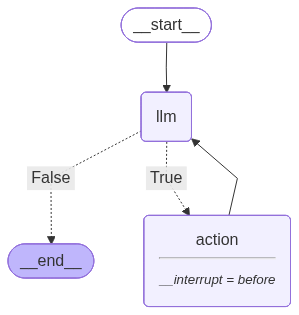

In [10]:
from IPython.display import Image, display

print("\n--- Tratando genterar el PNG del Grafo vía Mermaid ---")
try:
    image_data = abot.graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))

except AttributeError:
    print("Método `.draw_mermaid_png()` no encontrado o sin soporte.")
    print("Tratando generar únicamente el código Mermaid...")
    try:
        mermaid_code = abot.graph.get_graph().draw_mermaid()
        print("\n--- Código Mermaid Generado (Pegado en https://mermaid.live/) ---")
        print(mermaid_code)
    except Exception as e_mermaid:
        print(f"Error al generar el código Mermaid: {e_mermaid}")

except Exception as e:
    print(f"Error inesperado al tratar generar el grafo: {e}")

In [11]:
from IPython.display import Image, display
import uuid

new_session_id = str(uuid.uuid4())
print(f"DEBUG: Iniciando una nueva conversación con ID: {new_session_id}\n")
new_user_message = "Cuál es la distancia entre CDMX y Tokio?"
new_messages = [HumanMessage(content=new_user_message)]
new_thread_config = {"configurable": {"thread_id": new_session_id}}

print("--- Iniciando Nueva Interacción: Agente procesa la entrada y recibe la acción ---")
print(f"Usted: {new_user_message}")
print(f"DEBUG: ID del nuevo hilo: {new_session_id}")

print("\n--- Agente pensando y pausando ---")
try:
    for event in abot.graph.stream({"messages": new_messages}, new_thread_config):
        for k, v in event.items():
            if k == "llm":
                if v and 'messages' in v and v['messages']:
                    llm_message_from_event = v['messages'][0]
                    if hasattr(llm_message_from_event, 'tool_calls') and llm_message_from_event.tool_calls:
                        print(f"\nAgente (decisión): {llm_message_from_event.tool_calls}")
                        print("\n--- AGENTE PAUSADO: Intervención humana necesaria ---")
                        
                    elif llm_message_from_event.content:
                        print(f"\nAgente (respuesta directa): {llm_message_from_event.content}")
                        print("\n--- AGENTE NO PAUSÓ POR LA HERRAMIENTA (Respuesta directa de la LLM) ---")
except Exception as e:
    print(f"DEBUG: Stream interrumpido como esperado: {e}")

current_state_snapshot = abot.graph.get_state(new_thread_config)

if current_state_snapshot:
    print(f"\nDEBUG: Estado actual obtenido para el nuevo ID del hilo: {new_session_id}")
    
    snapshot_thread_id = None
    snapshot_thread_ts = None

    if hasattr(current_state_snapshot, 'config') and isinstance(current_state_snapshot.config, dict):
        if 'configurable' in current_state_snapshot.config and isinstance(current_state_snapshot.config['configurable'], dict):
            if 'thread_id' in current_state_snapshot.config['configurable']:
                snapshot_thread_id = current_state_snapshot.config['configurable']['thread_id']
            if '__run_id' in current_state_snapshot.config['configurable']:
                snapshot_thread_ts = current_state_snapshot.config['configurable']['__run_id']
            elif 'thread_ts' in current_state_snapshot.config['configurable']:
                snapshot_thread_ts = current_state_snapshot.config['configurable']['thread_ts']
    
    if snapshot_thread_id is None:
        snapshot_thread_id = new_session_id

    print(f"DEBUG: ID del Hilo (del snapshot): {snapshot_thread_id}")
    print(f"DEBUG: Timestamp del snapshot (thread_ts): {snapshot_thread_ts}") 
    print(f"DEBUG: Mensajes en el snapshot (al momento de la pausa): {current_state_snapshot.values.get('messages')}")
    
    if current_state_snapshot.values and 'messages' in current_state_snapshot.values:
        last_msg_in_snapshot = current_state_snapshot.values['messages'][-1]
        print(f"DEBUG: Tipo del último mensaje en el snapshot para la inyección: {type(last_msg_in_snapshot)}")
        if hasattr(last_msg_in_snapshot, 'tool_calls') and last_msg_in_snapshot.tool_calls:
            print(f"DEBUG: Último mensaje en el snapshot CONTIENE tool_calls. LISTO PARA LA INYECCIÓN!")
        else:
            print(f"DEBUG: Último mensaje en el snapshot NO CONTIENE tool_calls o está vacío. PROBLEMA EN LA PAUSA!")
    if current_state_snapshot.next != ():
        print("\n--- Agente PAUSADO y listo para la intervención. ---")
    else:
        print("\n--- ATENCIÓN: El agente NO está pausado donde debería. El grafo puede haber finalizado. ---")
else:
    print(f"DEBUG: Ningún estado encontrado para el nuevo ID de hilo: {new_session_id}. Verifique la configuración del hilo o si el agente pausó.")

DEBUG: Iniciando una nueva conversación con ID: 9bea0ad7-2ad3-438e-a97d-ae997316ddb3

--- Iniciando Nueva Interacción: Agente procesa la entrada y recibe la acción ---
Usted: Cuál es la distancia entre CDMX y Tokio?
DEBUG: ID del nuevo hilo: 9bea0ad7-2ad3-438e-a97d-ae997316ddb3

--- Agente pensando y pausando ---
{'messages': [HumanMessage(content='Cuál es la distancia entre CDMX y Tokio?', additional_kwargs={}, response_metadata={}, id='a9d110dc-77c6-4f51-bf37-94002eea328a'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "distancia entre CDMX y Tokio"}'}, '__gemini_function_call_thought_signatures__': {'9daf38c7-0eec-4f2a-b0cf-28b24a618bfe': 'CqILAXLI2nzMxD7NbI8ezhM2oIk0lSobczYdxVIq1EKqxBjEuOTM0sfhDdvnPmP41N3RHtYZPTQ8CQIvAyWD6PRH9+ERNqrR841OyBS0to5aVXcYAn14rWMQrhJpqQ0dipqn00aLKUjkcmgp9YqAGWC0CB7GI7VFZu1zjYxo53ITHjYfPwCu4JT+eungy9beQiXixpoFUCAcRzhUZ7uLTMwQoH/CX/oK3UojyUITOTpP3p4KSQNOrqFd6tp0KmgmYFH8rsh0y+C5nCtI4

In [12]:
from langchain_core.messages import AIMessage

if current_state_snapshot:
    modified_state_values = current_state_snapshot.values.copy()

    final_injected_message = AIMessage(
        content="La distancia entre CDMX y Tokio es de aproximadamente 450 km. (Datos introducidos manualmente por usted!)"
    )
    ai_message_found = False
    for i, msg in enumerate(modified_state_values['messages']):
        
        if isinstance(msg, AIMessage):
            modified_state_values['messages'] = modified_state_values['messages'][:i] + [final_injected_message]
            ai_message_found = True
            break
            
    if not ai_message_found:
        modified_state_values['messages'].append(final_injected_message)

    print("\n--- Estado siendo MODIFICADO MANUALMENTE (Inyectando AIMessage Final) ---")
    print(f"DEBUG: Contenido del AIMessage falso inyectado: {final_injected_message.content}")
    print(f"DEBUG: Nueva lista de mensajes (últimos): {[m.type for m in modified_state_values['messages'][-2:]]}")

else:
    print("DEBUG: No es posible modificar el estado porque ningún snapshot del estado fue encontrado.")


--- Estado siendo MODIFICADO MANUALMENTE (Inyectando AIMessage Final) ---
DEBUG: Contenido del AIMessage falso inyectado: La distancia entre CDMX y Tokio es de aproximadamente 450 km. (Datos introducidos manualmente por usted!)
DEBUG: Nueva lista de mensajes (últimos): ['human', 'ai']


In [13]:
print("\n--- Finalizando el estado con la respuesta inyectada ---")

abot.graph.update_state(new_thread_config, modified_state_values)

final_state_after_injection_obj = abot.graph.get_state(new_thread_config)

print("\n--- Salida final del agente tras la intervención ---")

if hasattr(final_state_after_injection_obj, 'values') and isinstance(final_state_after_injection_obj.values, dict):
    final_messages = final_state_after_injection_obj.values['messages']
elif isinstance(final_state_after_injection_obj, dict):
    final_messages = final_state_after_injection_obj['messages']

else:
    found_messages_list = None
    if isinstance(final_state_after_injection_obj, tuple):
        for item in final_state_after_injection_obj:
            if isinstance(item, dict) and 'messages' in item:
                found_messages_list = item['messages']
                break
    elif isinstance(final_state_after_injection_obj, dict) and 'messages' in final_state_after_injection_obj:
        found_messages_list = final_state_after_injection_obj['messages']
    
    if found_messages_list is not None:
        final_messages = found_messages_list
    else:
        print(f"DEBUG: No fue posible extraer la lista de mensajes del estado del objeto al final: {final_state_after_injection_obj}")
        final_messages = []

if final_messages and isinstance(final_messages[-1], AIMessage):
    print(f"\nAgente: {final_messages[-1].content}")
else:
    print("\nAgente: Resposta final no fue encontrada o no es AIMessage.")
    print(f"DEBUG: Estado final completo (para inspección): {final_state_after_injection_obj}")

print("\n--- Flujo de Human-in-the-Loop concluído ---")


--- Finalizando el estado con la respuesta inyectada ---
{'messages': [HumanMessage(content='Cuál es la distancia entre CDMX y Tokio?', additional_kwargs={}, response_metadata={}, id='a9d110dc-77c6-4f51-bf37-94002eea328a'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "distancia entre CDMX y Tokio"}'}, '__gemini_function_call_thought_signatures__': {'9daf38c7-0eec-4f2a-b0cf-28b24a618bfe': 'CqILAXLI2nzMxD7NbI8ezhM2oIk0lSobczYdxVIq1EKqxBjEuOTM0sfhDdvnPmP41N3RHtYZPTQ8CQIvAyWD6PRH9+ERNqrR841OyBS0to5aVXcYAn14rWMQrhJpqQ0dipqn00aLKUjkcmgp9YqAGWC0CB7GI7VFZu1zjYxo53ITHjYfPwCu4JT+eungy9beQiXixpoFUCAcRzhUZ7uLTMwQoH/CX/oK3UojyUITOTpP3p4KSQNOrqFd6tp0KmgmYFH8rsh0y+C5nCtI4HWEf5k9YBOKt4N9ppAlhVrE0HQnJx0DtHBDVjjpWl5HuH2I6oZNWc0nDQVCCCz9XEMEustKg34AoRHUHMs8c65hXWEVcir3Y2gdncqos49Hez/i+TojLirK7eS/sSr1KuO/4hTVoyiNs02JXFvSV5J8FYv0upT497z5VfHTMvoQEO/+90zGmavx58nLVakIxuk8rGpxcXPeP0d8ynKBkldKNR0YWu6KO1/faLi3sr2oEXph1qMdR9585jHjTeoaCk